In [2]:
import sqlite3

# Connect to SQLite database (it will create one if it doesn't exist)
conn = sqlite3.connect("coffee_supply.db")
cursor = conn.cursor()

In [9]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS countries (
    country_id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    region TEXT,
    production_volume INTEGER 
)
""")

In [10]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS suppliers (
    supplier_id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    country_id INTEGER,
    rating REAL,  -- scale of 1 to 5
    FOREIGN KEY(country_id) REFERENCES countries(country_id)
)
""")

In [4]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS shipments (
    shipment_id INTEGER PRIMARY KEY,
    supplier_id INTEGER,
    date TEXT,
    quantity_kg INTEGER,
    co2_kg REAL,
    lead_time_days INTEGER,
    FOREIGN KEY(supplier_id) REFERENCES suppliers(supplier_id)
)
""")

In [5]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS prices (
    price_id INTEGER PRIMARY KEY,
    country_id INTEGER,
    month TEXT,
    price_per_kg REAL,
    FOREIGN KEY(country_id) REFERENCES countries(country_id)
)
""")

In [6]:
conn.commit()

In [7]:
countries_data = [
    (1, 'Brazil', 'South America', 3000000),
    (2, 'Vietnam', 'Asia', 1800000),
    (3, 'Colombia', 'South America', 900000)
]

cursor.executemany("""
INSERT INTO countries (country_id, name, region, production_volume)
VALUES (?, ?, ?, ?)
""", countries_data)

suppliers_data = [
    (1, 'Amazon Beans Ltd.', 1, 4.7),
    (2, 'Saigon Coffee Co.', 2, 4.2),
    (3, 'Bogotá Brews', 3, 4.5),
    (4, 'Rainforest Roasters', 1, 4.8)
]

cursor.executemany("""
INSERT INTO suppliers (supplier_id, name, country_id, rating)
VALUES (?, ?, ?, ?)
""", suppliers_data)

shipments_data = [
    (1, 1, '2025-01-15', 10000, 320.5, 20),
    (2, 2, '2025-01-20', 8500, 290.0, 25),
    (3, 3, '2025-02-10', 9200, 310.8, 23),
    (4, 4, '2025-02-28', 11000, 340.2, 18),
    (5, 1, '2025-03-05', 10500, 330.1, 21),
    (6, 2, '2025-03-12', 8700, 300.0, 24)
]

cursor.executemany("""
INSERT INTO shipments (shipment_id, supplier_id, date, quantity_kg, co2_kg, lead_time_days)
VALUES (?, ?, ?, ?, ?, ?)
""", shipments_data)

prices_data = [
    (1, 1, '2025-01', 4.05),
    (2, 2, '2025-01', 3.96),
    (3, 3, '2025-01', 4.20),
    (4, 1, '2025-02', 4.09),
    (5, 2, '2025-02', 3.98),
    (6, 3, '2025-02', 4.22),
    (7, 1, '2025-03', 4.12),
    (8, 2, '2025-03', 4.00),
    (9, 3, '2025-03', 4.25)
]

cursor.executemany("""
INSERT INTO prices (price_id, country_id, month, price_per_kg)
VALUES (?, ?, ?, ?)
""", prices_data)

conn.commit()

IntegrityError: UNIQUE constraint failed: countries.country_id

In [3]:
import pandas as pd

# Connect again if needed
conn = sqlite3.connect("coffee_supply.db")

In [4]:
query_volume = """
SELECT c.name AS country, SUM(s.quantity_kg) AS total_export_kg
FROM shipments s
JOIN suppliers sup ON s.supplier_id = sup.supplier_id
JOIN countries c ON sup.country_id = c.country_id
GROUP BY c.name
ORDER BY total_export_kg DESC
"""

df_volume = pd.read_sql_query(query_volume, conn)
print(df_volume)

    country  total_export_kg
0    Brazil            31500
1   Vietnam            17200
2  Colombia             9200


In [5]:
query_co2_lead = """
SELECT sup.name AS supplier, s.date, s.quantity_kg, s.co2_kg, s.lead_time_days
FROM shipments s
JOIN suppliers sup ON s.supplier_id = sup.supplier_id
"""

df_co2 = pd.read_sql_query(query_co2_lead, conn)
print(df_co2)

              supplier        date  quantity_kg  co2_kg  lead_time_days
0    Amazon Beans Ltd.  2025-01-15        10000   320.5              20
1    Saigon Coffee Co.  2025-01-20         8500   290.0              25
2         Bogotá Brews  2025-02-10         9200   310.8              23
3  Rainforest Roasters  2025-02-28        11000   340.2              18
4    Amazon Beans Ltd.  2025-03-05        10500   330.1              21
5    Saigon Coffee Co.  2025-03-12         8700   300.0              24


In [6]:
query_prices = """
SELECT c.name AS country, p.month, p.price_per_kg
FROM prices p
JOIN countries c ON p.country_id = c.country_id
ORDER BY p.month
"""

df_prices = pd.read_sql_query(query_prices, conn)
print(df_prices)

    country    month  price_per_kg
0    Brazil  2025-01          4.05
1   Vietnam  2025-01          3.96
2  Colombia  2025-01          4.20
3    Brazil  2025-02          4.09
4   Vietnam  2025-02          3.98
5  Colombia  2025-02          4.22
6    Brazil  2025-03          4.12
7   Vietnam  2025-03          4.00
8  Colombia  2025-03          4.25


In [7]:
query_ratings = """
SELECT s.name AS supplier, s.rating, c.name AS country
FROM suppliers s
JOIN countries c ON s.country_id = c.country_id
"""

df_ratings = pd.read_sql_query(query_ratings, conn)
print(df_ratings)

              supplier  rating   country
0    Amazon Beans Ltd.     4.7    Brazil
1    Saigon Coffee Co.     4.2   Vietnam
2         Bogotá Brews     4.5  Colombia
3  Rainforest Roasters     4.8    Brazil


In [8]:
%pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


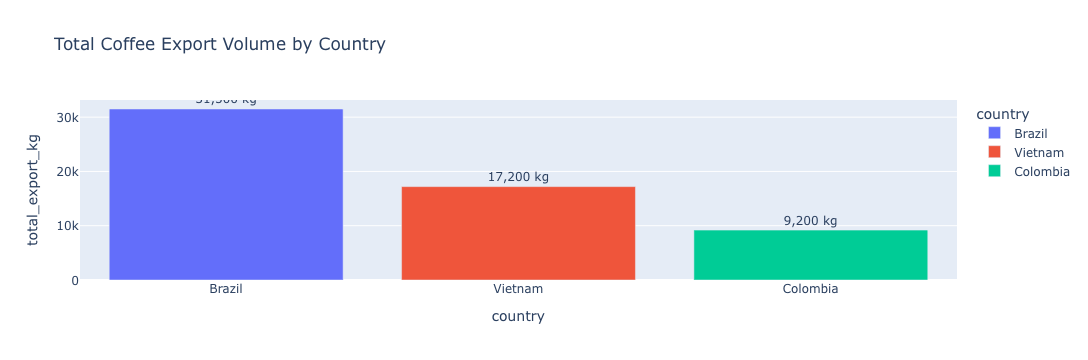

In [9]:
import plotly.express as px

fig1 = px.bar(
    df_volume,
    x='country',
    y='total_export_kg',
    color='country',
    title='Total Coffee Export Volume by Country',
    text='total_export_kg'
)

fig1.update_traces(texttemplate='%{text:,} kg', textposition='outside')
fig1.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig1.show()

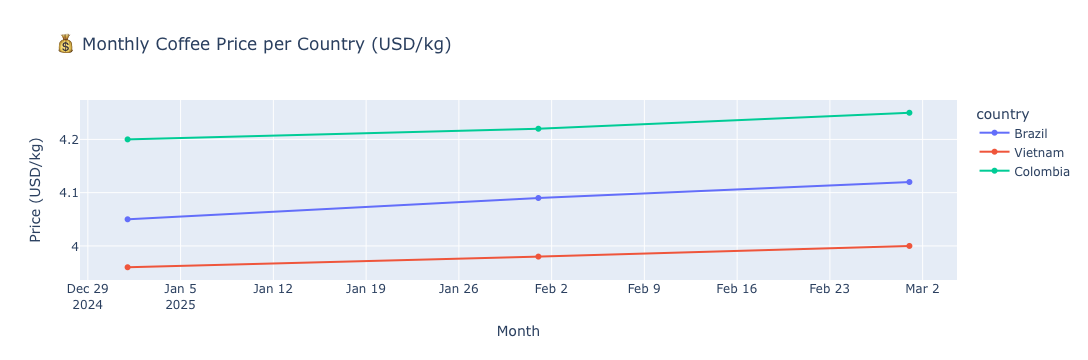

In [10]:
fig2 = px.line(
    df_prices,
    x='month',
    y='price_per_kg',
    color='country',
    markers=True,
    title='💰 Monthly Coffee Price per Country (USD/kg)'
)

fig2.update_layout(yaxis_title='Price (USD/kg)', xaxis_title='Month')
fig2.show()

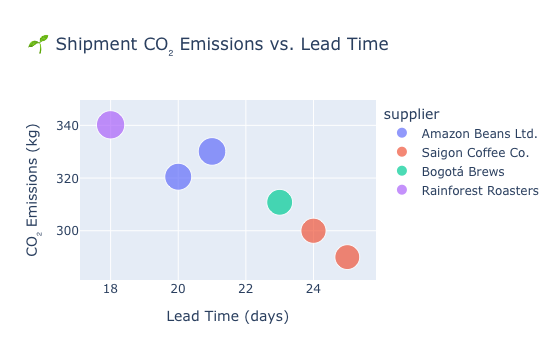

In [11]:
fig3 = px.scatter(
    df_co2,
    x='lead_time_days',
    y='co2_kg',
    size='quantity_kg',
    color='supplier',
    hover_name='supplier',
    title='🌱 Shipment CO₂ Emissions vs. Lead Time',
    labels={'lead_time_days': 'Lead Time (days)', 'co2_kg': 'CO₂ Emissions (kg)'}
)

fig3.show()

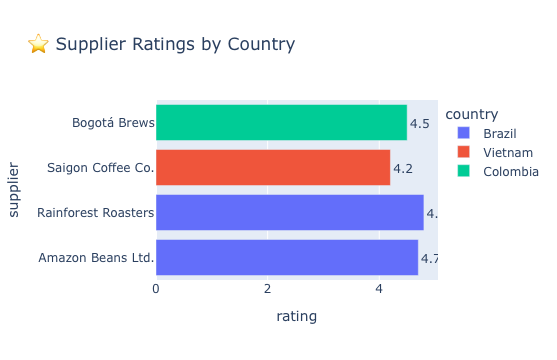

In [12]:
fig4 = px.bar(
    df_ratings,
    x='rating',
    y='supplier',
    color='country',
    orientation='h',
    title='⭐ Supplier Ratings by Country',
    text='rating'
)

fig4.update_traces(texttemplate='%{text}', textposition='outside')
fig4.show()